<h1><center>Sentiment analysis of climate change tweets</center></h1>

<center>HEDFI Houeida, MEFENZA NOUNTU Thierry</center>

Climate change is one of the biggest subjects that preoccupies the whole wide world today. There is a lot of controversy about this topic: while some people believe that it is a reality and is caused by human behavior,  some people believe in it but think that it is not related to human activities and some do not even believe and think that it a pure human invention. Nowadays, people use different social media networks to express themselves and Tweeter is among the popular ones. We suppose that the sentiments expressed by people about this topic really reflects what they do in their daily life to fight against this major issue. Moreover, the sentiments of people towards climate change is an indicator for their political choices and for the election of national leaders and has a tremendous effect on anti-climate change national measures taken.

In this project, we will analyze a dataset containing people’s sentiments on climate change based on their tweets. This dataset can be found in:
\url{https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset}

Our project will be organized as follows. We will do some preprocessing on the dataset (cleaning, encoding, tokenization, etc ) and explore the dataset. Then we will construct models (Random Forest, Neural Network, KNN, LSTM, etc) based on Word2vec or BERT. We will end up evaluating it qualitatively and quantitatively using the F1 score and computed on the test set of our dataset and Roc curve. We will end this project by a conclusion and some possible future work.


**Import packages**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

**Load Dataset**

In [2]:
data = pd.read_csv('twitter_sentiment_data.csv')

In [3]:
data

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153
...,...,...,...
43938,1,"Dear @realDonaldTrump,\nYeah right. Human Medi...",791307031919550464
43939,1,What will your respective parties do to preven...,791316857403936768
43940,2,RT @MikkiL: UN Poll Shows Climate Change Is th...,791357509101621249
43941,0,RT @taehbeingextra: i still can$q$t believe th...,791390042136641537


# 1. Data Balance

In [4]:
print(len(data.loc[data['sentiment']==1]), 'Positive Tweets.')
print(len(data.loc[data['sentiment']==0]), 'Neutral Tweets.')
print(len(data.loc[data['sentiment']==-1]), 'Negative Tweets.')
print(len(data.loc[data['sentiment']==2]), 'News Tweets.')
print('')
print('Our data are imbalanced, we will need to perform undersampling.')

22962 Positive Tweets.
7715 Neutral Tweets.
3990 Negative Tweets.
9276 News Tweets.

Our data are imbalanced, we will need to perform undersampling.


In [5]:
data['sentiment'].unique()

array([-1,  1,  2,  0])

In [6]:
data['message'].iloc[2400]

'Donald proposed banning an entire religion,encouraged violence at his rallies,called global warming a hoax but yeaa how do you choose Ã°Å¸Â¤â€\x9d'

In [7]:
data['sentiment'].iloc[2400]

1

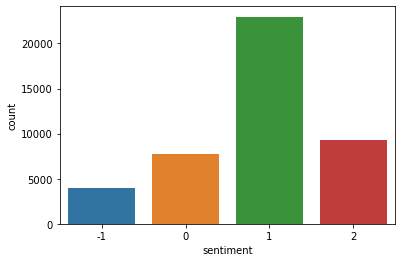

In [8]:
ax=sns.countplot(x="sentiment", data=data)
ax.set_xticklabels(ax.get_xticklabels())
plt.show()

# 2. Check if there are duplicated tweets

In [9]:
print(len(data.message))
print(len(set(data.message)))
print(data.shape)

43943
41033
(43943, 3)


In [10]:
print('There is', len(data.message), 'Tweets in total. But there is only', len(set(data.message)), 'unique tweets.')

There is 43943 Tweets in total. But there is only 41033 unique tweets.


In [11]:
# Droping duplicates
data2=data.drop_duplicates(subset=['message'])
data2.shape

(41033, 3)

# 3. Split the tweets into list of words using .split

In [12]:
data_splitted=data2.message.apply(lambda x: x.split(' ')).array
data_splitted[:10]

<PandasArray>
[['@tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom'],
             ['RT', '@NatGeoChannel:', 'Watch', '#BeforeTheFlood', 'right', 'here,', 'as', '@LeoDiCaprio', 'travels', 'the', 'world', 'to', 'tackle', 'climate', 'change', 'https://t.co/LkDehj3tNn', 'httÃ¢â‚¬Â¦'],
                                                   ['Fabulous!', 'Leonardo', "#DiCaprio's", 'film', 'on', '#climate', 'change', 'is', 'brilliant!!!', 'Do', 'watch.', 'https://t.co/7rV6BrmxjW', 'via', '@youtube'],
                ['RT', '@Mick_Fanning:', 'Just', 'watched', 'this', 'amazing', 'documentary', 'by', 'leonardodicaprio', 'on', 'climate', 'change.', 'We', 'all', 'think', 'thisÃ¢â‚¬Â¦', 'https://t.co/kNSTE8K8im'],
        ['RT', '@cnalive:', 'Pranita', 'Biswasi,', 'a', 'Lutheran', 'from', 'Odisha,', 'gives', 'testimony', 'on', 'effects', 'of', 'c

In [13]:
len(data_splitted)

41033

In [14]:
from functools import reduce
from operator import add

In [15]:
data_splitted_concatenated=reduce(add, data_splitted)
data_splitted_concatenated[:10]

['@tiniebeany',
 'climate',
 'change',
 'is',
 'an',
 'interesting',
 'hustle',
 'as',
 'it',
 'was']

In [16]:
print('With .split:')
print('The tweets corpus has', len(data_splitted_concatenated), 'words')
print('There are only', len(set(data_splitted_concatenated)), '(unique) words in the vocabulary')

With .split:
The tweets corpus has 704307 words
There are only 116049 (unique) words in the vocabulary


# 4. Split the tweets into list of words using three different tokenizers from nltk

In [17]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import TweetTokenizer

**TreebankWordTokenizer**

In [18]:
data_TWT = data2.message.apply(lambda x: TreebankWordTokenizer().tokenize(x)).array
data_TWT_contatenated = reduce(add, data_TWT) # Concatenates all lists contained in arr_TWT
len(set(data_TWT_contatenated)) # the set object transforms a list to the set of unique elements in the list 

95742

In [19]:
print('With TreebankWordTokenizer:')
print('The tweets corpus has', len(data_TWT_contatenated), 'words.') 
print('There are only', len(set(data_TWT_contatenated)), 
     '(unique) words in the vocabulary.')

With TreebankWordTokenizer:
The tweets corpus has 906875 words.
There are only 95742 (unique) words in the vocabulary.


**ToktokTokenizer**

In [20]:
data_TTT = data2.message.apply(lambda x: ToktokTokenizer().tokenize(x)).array
data_TTT_contatenated = reduce(add, data_TTT) # Concatenates all lists contained in arr_TWT

In [21]:
print('With ToktokTokenizer:')
print('The tweets corpus has', len(data_TTT_contatenated), 'words.') 
print('There are only', len(set(data_TTT_contatenated)), 
     '(unique) words in the vocabulary.')

With ToktokTokenizer:
The tweets corpus has 836434 words.
There are only 94278 (unique) words in the vocabulary.


**TweetTokenizer**

In [22]:
data_TweetT = data2.message.apply(lambda x: TweetTokenizer().tokenize(x)).array
data_TweetT_contatenated = reduce(add, data_TweetT)

In [23]:
print('With TweetTokenizer:')
print('The tweets corpus has', len(data_TweetT_contatenated), 'words.') 
print('There are only', len(set(data_TweetT_contatenated)), 
     '(unique) words in the vocabulary.')

With TweetTokenizer:
The tweets corpus has 856576 words.
There are only 87951 (unique) words in the vocabulary.


In [24]:
data_TweetT_contatenated[:10]

['@tiniebeany',
 'climate',
 'change',
 'is',
 'an',
 'interesting',
 'hustle',
 'as',
 'it',
 'was']

**Spacy Tokenizer**

In [25]:
from spacy.tokenizer import Tokenizer 
from spacy.lang.en import English

In [26]:
tokenizer = Tokenizer(English().vocab)

data_ST = data2.message.apply(lambda x: [w.text for w in tokenizer(x)]).array
data_ST_contatenated = reduce(add, data_ST)

In [27]:
print('With Spacy Tokenizer:')
print('The tweets corpus has', len(data_ST_contatenated), 'words.') 
print('There are only', len(set(data_ST_contatenated)), 
     '(unique) words in the vocabulary.')

With Spacy Tokenizer:
The tweets corpus has 713614 words.
There are only 114307 (unique) words in the vocabulary.


**Descriptive Statistics**

In [28]:
# Création d'un Data Frame avec les données des nombres de mots

# initialize list of lists
quanti = [['.split', 704307, 116049], ['TreebankWordTokenizer', 906875, 95742], ['ToktokTokenizer', 836434, 94278], 
        ['TweetTokenizer', 856576, 87951], ['Spacy Tokenizer', 713614, 114307]]

# Create the pandas DataFrame
quanti = pd.DataFrame(quanti, columns = ['Tokenizer', 'words', 'unique_words'])
quanti

,Tokenizer,words,unique_words
0,.split,704307,116049
1,TreebankWordTokenizer,906875,95742
2,ToktokTokenizer,836434,94278
3,TweetTokenizer,856576,87951
4,Spacy Tokenizer,713614,114307


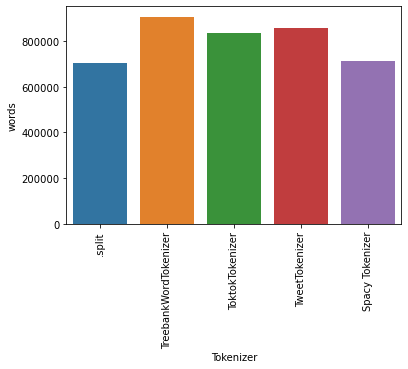

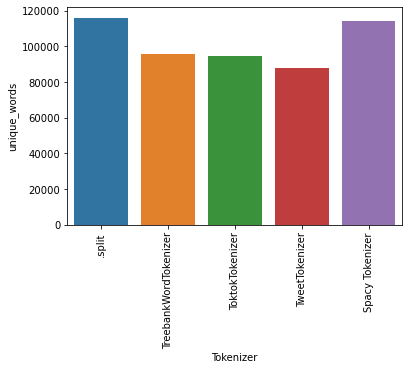

In [29]:
ax=sns.barplot(x="Tokenizer", y="words", data=quanti)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()
ax1=sns.barplot(x="Tokenizer", y="unique_words", data=quanti)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.show()

# 5. Check if Zipf's law applies

In [31]:
# This import allows you to count the occurrences of each different elements in a list
from collections import Counter

In [32]:
# We use reduce to concatenate all the lists in arr, but we don't use "set" 
# so that we can count occurencies with a Counter object 
c = Counter(data_TweetT_contatenated)
#print(c)

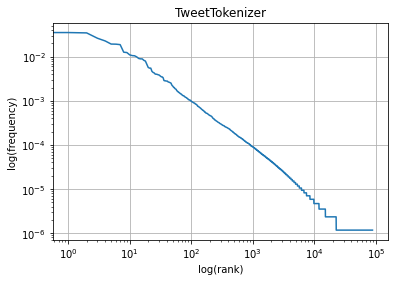

In [33]:
# Formating the counter object to a proper dataset
d = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d.columns=['word', 'occurences']
# Computing frequencies instead of occurences
nb_total = d.occurences.sum() # Nombre total d'occurrences
d['freq'] = d.occurences.apply(lambda x: x/nb_total) # pour chaque valeur dans occurrence, on calcule la fréquence
# Sorting by frequency, most frequent word at the top of the df
d = d.sort_values('freq', ascending=False)
plt.figure()
plt.grid()
plt.xscale('log')  # Using log scale
plt.yscale('log')  # Using log scale
plt.xlabel('log(rank)')
plt.ylabel('log(frequency)')
plt.title('TweetTokenizer')
x = list(range(d.shape[0]))
plt.plot(x, d.freq)
plt.show()

In [34]:
# Nombre de mots uniques après TweetT
len(x)

87951

In [35]:
d.head()

,word,occurences,freq
2,change,30366,0.035450
24,:,30194,0.035250
1,climate,29640,0.034603
22,RT,22406,0.026158
53,.,19472,0.022732


# 6. Cleaning the corpus

**Compter les mots qui commencent par @**

In [36]:
new=[]
for x in data_TweetT_contatenated:
    if x.startswith('@'):
        new.append(x)
new[:10]

['@tiniebeany',
 '@NatGeoChannel',
 '@LeoDiCaprio',
 '@youtube',
 '@Mick_Fanning',
 '@cnalive',
 '@CCIRiviera',
 '@AmericanIndian8',
 '@LeoDiCaprio',
 '@DrDeJarnett']

In [39]:
c_new=Counter(new)
#print(c_new[:30])

In [40]:
#############

In [41]:
# We tokenize the new tweets using TweetTokenizer
from nltk.tokenize import TweetTokenizer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/Hou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Cleaning function**

In [42]:
from tqdm import tqdm
import string
import re
import nltk

#delete '#' in each tweet
def remove_hashtags(tokens):
    tokens = map(lambda x: x.replace('#', ''), tokens)
    return list(tokens)

#delete http links in each tweet

def remove_url(tokens):
    tokens = filter(lambda x: "http" not in x, tokens)
    return list(tokens)

#delete html block in each tweet
def remove_html(tokens):
    tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
    return list(tokens)

#delete RT  in each tweet

def remove_retweet(tokens):
    tokens = filter(lambda x: x!= 'RT', tokens)
    return list(tokens)

def remove_special_characters(tokens):
    tokens = filter(lambda x: x!= 'â', tokens)
    return list(tokens)

def remove_special_characters2(tokens):
    tokens = filter(lambda x: x!= '¢', tokens)
    return list(tokens)

def remove_special_characters3(tokens):
    tokens = filter(lambda x: x!= 'ã', tokens)
    return list(tokens)


#delete names in each tweet
def remove_name(tokens):
    #tokens = filter(lambda x: x.startswith('@')==False , tokens)
    tokens = map(lambda x: x.replace('@', ''), tokens)

    return list(tokens)

#delete some punctuation

punctuation='‚¬¦'+string.punctuation  #Defining a list of punctuation to remove

def remove_punctuation(tokens):
    tokens = filter(lambda x: x not in punctuation, tokens)
    return list(tokens)


#delete some words from stopwords
stopword = nltk.corpus.stopwords.words('english')

def remove_word(tokens):
    tokens = filter(lambda x: x not in stopword, tokens)
    return list(tokens)



def tokenized_cleaned_tweets(corpus):
    tokenizer = TweetTokenizer() 
    tokenized_sentences = []
    for sample in tqdm(corpus):
        sample=re.sub('[0-9]+', '', sample) #remove numbers in the tweet
        tokens = tokenizer.tokenize(sample)
        tokens = remove_url(tokens)
        tokens = remove_html(tokens)
        tokens = remove_hashtags(tokens)
        tokens = remove_retweet(tokens)
        tokens = remove_name(tokens)
        tokens = remove_punctuation(tokens)
        tokens = remove_word(tokens)  #removing some words
        tokens = remove_special_characters(tokens)
        tokens = list(map(lambda x: x.lower(), tokens))
        tokens = remove_special_characters(tokens)
        tokens = remove_special_characters2(tokens)
        tokens = remove_special_characters3(tokens)
        tokenized_sentences.append(tokens)
    return tokenized_sentences


In [43]:
cleaned_data=tokenized_cleaned_tweets(data2.message.array)

100%|██████████| 41033/41033 [00:06<00:00, 6508.73it/s]


In [44]:
data2.message[3]

'RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im'

In [45]:
cleaned_data[3]

['mick_fanning',
 'just',
 'watched',
 'amazing',
 'documentary',
 'leonardodicaprio',
 'climate',
 'change',
 'we',
 'think',
 'thisã']

In [46]:
len(cleaned_data)

41033

# 7. Train, test, dev split

In [46]:
X = data2.loc[:, "message"]
y = data2.sentiment
print(X.shape)
print(y.shape)

(41041,)
(41041,)


In [47]:
# Clean X
X_cleaned=tokenized_cleaned_tweets(X.array)

100%|██████████| 41041/41041 [00:07<00:00, 5222.29it/s]


In [48]:
len(X_cleaned)

41041

In [49]:
import numpy as np
from sklearn.model_selection import train_test_split

In [50]:
# create train 60% 
X_train, X_devtest, y_train, y_devtest = train_test_split(X_cleaned, y, test_size=0.4, random_state=42)

In [51]:
# create dev 20% test 20% (hence 50% from the 40%)
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)

In [52]:
print(len(X_train))
print(len(y_train))

24624
24624


In [53]:
# Processing Labels (y)

from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)
y_train_lb = lb_trained.transform(y_train)
y_dev_lb = lb_trained.transform(y_dev)
print(y_train_lb.shape, y_dev_lb.shape)

(24624, 4) (8208, 4)


In [54]:
y_train_lb[:10]

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]])

In [55]:
y_train[:10]

34573    1
27025    2
38417    1
20327    2
3372     1
38430    0
4580     0
12670    0
35508   -1
33079    0
Name: sentiment, dtype: int64

In [56]:
y_test

43933    1
9111     2
14298    0
31503    2
34409    0
        ..
29754    1
15591    1
5166     1
20451   -1
14842    1
Name: sentiment, Length: 8209, dtype: int64

# 8. Word Embedding and prediction

# 8.1. Train a Word2Vec model with Gensim

In [57]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

# We will just get the "WordVectors" parameter from the trained Word2Vec model.
# Otherwise, we could continue training with some more exemples that could be
# fed on the fly to the model.
print("Training the tweets W2V ...")
data_tweets = Word2Vec(X_cleaned, size=300, window=5, min_count=3, workers=cpu)
data_tweets.train(X_cleaned, total_examples=len(cleaned_data), epochs=100)        # mettre le X_train
data_tweets_wv = data_tweets.wv

The virtual instance has 8 cpus, that will be used to train the word2vec model
Training the tweets W2V ...


In [58]:
data_tweets.most_similar('environment')

<ipython-input-58-5af8cbbdcd42>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  data_tweets.most_similar('environment')


[('env', 0.28413495421409607),
 ('duty', 0.23475104570388794),
 ('agricultural', 0.22426390647888184),
 ('hurshal', 0.21617549657821655),
 ('environmentâ', 0.21610501408576965),
 ('medicare', 0.21081912517547607),
 ('agnst', 0.21062439680099487),
 ('publichealth', 0.19997963309288025),
 ('epa', 0.1999744474887848),
 ('overlook', 0.19913436472415924)]

In [59]:
# Create a function to transform the corpus into an embedding one
def tokens2vectors(tokenCorpus, model, n):
  ''' transforms our X into a list of list of vec (2D array) '''
  new_sample = list()
  for sample in tokenCorpus:
    tweetVecs = list()
    for token in sample:
      try: tweetVecs.append(model.get_vector(token))
      except: tweetVecs.append( np.zeros(n)) 
    vect=np.mean(tweetVecs, axis=0)
    new_sample.append(vect)
  
  return np.array(new_sample)

In [60]:
X_train_wv=tokens2vectors(X_train, data_tweets_wv, 300)

In [61]:
X_dev_wv=tokens2vectors(X_dev, data_tweets_wv, 300)

**Sentiment analysis classification with SVM**

In [62]:
#svc = svm.SVC(kernel='linear', probability=True)
svc = LinearSVC(verbose=1, random_state=42)
clf_svm1 = OneVsRestClassifier(svc, n_jobs=-1 ).fit(X_train_wv, y_train_lb)

In [63]:
y_pred_svm = clf_svm1.predict(X_dev_wv)
print(y_pred_svm.shape)
y_score_svm = clf_svm1.decision_function(X_dev_wv)

(8208, 4)


**Quantitative Analysis**

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

def show_eval(y_true, y_pred, lb_trained, clf):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print( classification_report(y_true_names, y_pred_names) )
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = [-1,  0,  1,  2]
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+str(label))
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

          -1       0.21      0.61      0.31       768
           0       0.69      0.24      0.35      1515
           1       0.72      0.72      0.72      4122
           2       0.76      0.56      0.65      1803

    accuracy                           0.58      8208
   macro avg       0.60      0.53      0.51      8208
weighted avg       0.68      0.58      0.60      8208



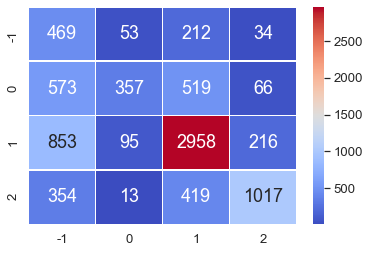

-1 0.6160744287634409
0 0.6074321775521345
1 0.714756640525642
2 0.7837268357057778


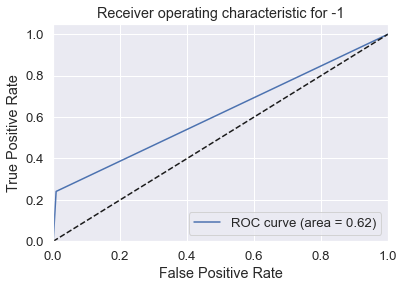

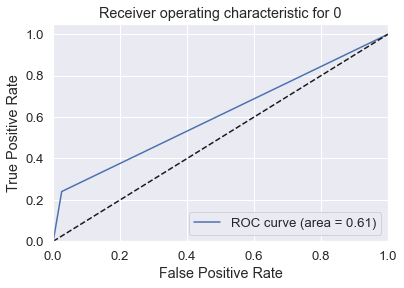

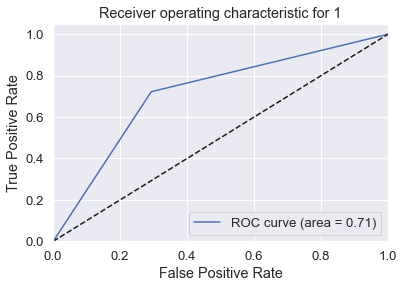

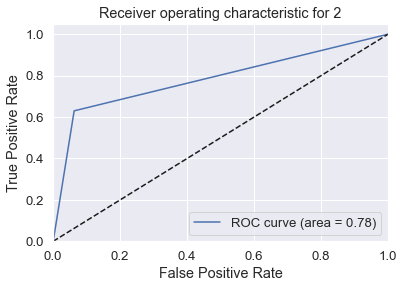

In [65]:
show_eval(y_dev_lb, y_pred_svm, lb_trained, clf_svm1)

According to our quantitative evaluation, we can observe that our predictor predict well when the true label is 1 (and even for the label 2), but it does not perform well on the neutral and the anti tweets.
The accuracy and the F1 score are not very high.

**Qualitative analysis of our prediction**

**Let's have a look on predictions to understand the reasons why our prediction scores are not good**

We create a dataframe with our dev data

In [69]:
y_pred1=clf_svm1.predict(X_dev_wv)

In [74]:
y_pred1=lb_trained.inverse_transform(y_pred1)

In [78]:
list(y_pred1)

[1,
 0,
 1,
 -1,
 1,
 -1,
 2,
 -1,
 1,
 2,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 0,
 -1,
 -1,
 2,
 1,
 1,
 2,
 -1,
 1,
 1,
 2,
 1,
 2,
 -1,
 1,
 1,
 -1,
 1,
 0,
 1,
 2,
 -1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 0,
 1,
 -1,
 1,
 2,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 2,
 2,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 0,
 2,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 0,
 1,
 -1,
 1,
 1,
 1,
 0,
 -1,
 -1,
 1,
 1,
 0,
 -1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 -1,
 1,
 0,
 1,
 2,
 1,
 1,
 -1,
 2,
 0,
 -1,
 1,
 1,
 1,
 1,
 0,
 -1,
 1,
 0,
 -1,
 -1,
 -1,
 -1,
 0,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 2,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 2,
 1,
 -1,
 1,
 0,
 -1,
 1,
 1,
 -1,
 2,
 2,
 1,
 -1,
 -1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 2,
 -1,
 -1,
 -1,
 -1,
 -1,
 2,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 2,
 2,
 -1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 -1,
 1,
 2,
 1,
 2,
 -1,
 1,
 2,
 -1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1

In [79]:
d = {'Cleaned_tweet': [' '.join(X_dev[i]) for i in range(len(X_dev))], 
     'Tweet Length':[len(' '.join(X_dev[i])) for i in range(len(X_dev))], 'True sentiment': y_dev, 
     'Predicted sentiment': y_pred1}
data3 = pd.DataFrame(data=d)
data3=data3.reset_index()

In [80]:
data3['Good prediction']=data3['True sentiment']==data3['Predicted sentiment']

In [81]:
data3.head()

,index,Cleaned_tweet,Tweet Length,True sentiment,Predicted sentiment,Good prediction
0,11784,adapting climate change means adapting trump n...,89,1,1,True
1,11290,beyoncepres i believe climate change election ...,76,0,0,True
2,31718,calgaryherald alberta reducing emissions unlik...,86,2,1,False
3,5846,if realdonaldtrump talks elonmusk climate chan...,109,0,-1,False
4,5452,un_spokesperson ban ki-moon cop no country how...,101,1,1,True


Do the length of the tweets have an influence on the prediction quality ?

In [82]:
# Average length of the tweets on X_dev
data3['Tweet Length'].mean()

82.67105263157895

In [83]:
# Average length of the well predicted tweets on X_dev
data3.loc[data3['True sentiment']==data3['Predicted sentiment'], 'Tweet Length'].mean()

83.29785461362216

In [84]:
# Average length of the predicted tweets on X_dev
data3.loc[data3['True sentiment']!=data3['Predicted sentiment'], 'Tweet Length'].mean()

81.78778984443792

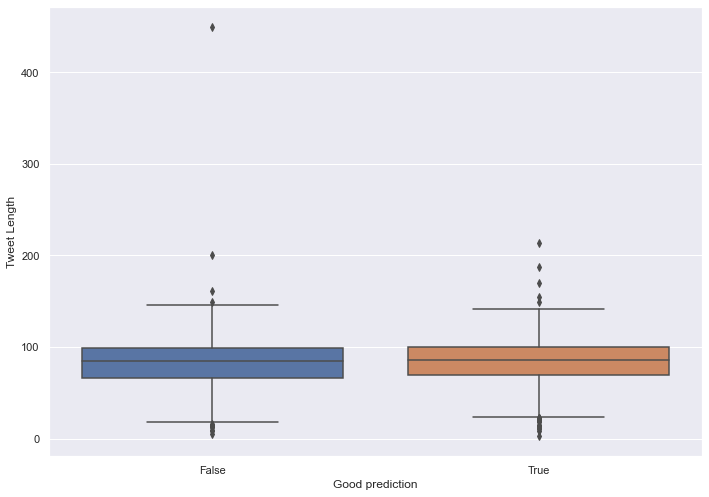

In [85]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="Good prediction", y="Tweet Length", data=data3)

We can see that the average length of the tweets well predicted is very close to the one of the tweets not well predicted. We have also made a boxplot, and we don't see any difference in the distribution of length among both groups. We conclude that the length has no effect on the prediction quality.

**Let's have a look on some of the tweets for which the sentiment prediction is false**

In [86]:
Data_wrong_pred=data3.loc[data3['True sentiment']!=data3['Predicted sentiment']]
Data_wrong_pred.reset_index(inplace=True)

In [87]:
# We print the first ten tweet with wrong sentiment prediction
for i in range(10):    
    print(i, Data_wrong_pred['Cleaned_tweet'][i],'.', 'y_true :', Data_wrong_pred['True sentiment'][i], 'y_pred :',
         Data_wrong_pred['Predicted sentiment'][i])

0 calgaryherald alberta reducing emissions unlikely live canada's climate change targets . y_true : 2 y_pred : 1
1 if realdonaldtrump talks elonmusk climate change makes japan pay hyper loop asia love ya japan i'll get boner . y_true : 0 y_pred : -1
2 epa epascottpruitt smarter means trusting scientists study environment agree co causes global warming . y_true : 1 y_pred : -1
3 judgment_al a million bottles minute world's plastic binge dangerous climate change . y_true : 1 y_pred : 2
4 speakeasyjames climate change crimes how insideous demented stupidity display . y_true : -1 y_pred : 1
5 nerylmcphee skynewsaust billshortenmp can put bill boat set adrift he might find climate change . y_true : 0 y_pred : -1
6 thehill gore i hope work trump climate change . y_true : 2 y_pred : -1
7 hi psa quit blaming ordinary citizens global warming start blaming corporations responsiblâ € . y_true : 1 y_pred : -1
8 anniebeans tofsa foxnewspolitics dumbfuck republicans refused believe global warming b 

The tweets observed above seem very ambigious even for a human being. Our predictor couldn't assimilate the complexity of tweets understanding. This could in part explain the scores that we obtained.

Let's try another algorithm

In [88]:
# GridSearchCV with kNN : a simple baseline
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier() # defining classifier
parameters = {'n_neighbors': [1, 2, 3, 4, 5]} # defining parameter space
clf = GridSearchCV(knn, parameters, cv=3)
clf.fit(X_train_wv, y_train)

print('Returned hyperparameter: {}'.format(clf.best_params_))
print('Best classification accuracy in train is: {}'.format(clf.best_score_))
print('Classification accuracy on test is: {}'.format(clf.score(X_dev_wv, y_dev)))

Returned hyperparameter: {'n_neighbors': 1}
Best classification accuracy in train is: 0.5326104613385315
Classification accuracy on test is: 0.5564083820662769


# 8.2. word2vec-google-news-300

In [89]:
## downloads and put in memory the famous pre-trained model from Google-News (embedding dimension = 300)
import gensim.downloader as api
model_gn = api.load("word2vec-google-news-300")

In [90]:
model_vocabulary = model_gn.vocab
len(model_vocabulary)

3000000

In [91]:
model_gn.most_similar('environment')

[('environments', 0.6948074102401733),
 ('enviroment', 0.648835301399231),
 ('environ_ment', 0.6331035494804382),
 ('enviornment', 0.6283591389656067),
 ('evironment', 0.6025119423866272),
 ('climate', 0.6009922027587891),
 ('envrionment', 0.5722888708114624),
 ('envi_ronment', 0.5690474510192871),
 ('environment.â_€', 0.551297664642334),
 ('environement', 0.5422993898391724)]

In [92]:
X_train_wv_g=tokens2vectors(X_train, model_gn, 300)

In [93]:
X_dev_wv_g=tokens2vectors(X_dev, model_gn, 300)

In [94]:
X_test_wv_g=tokens2vectors(X_test, model_gn, 300)

# SVM

In [95]:
svc = LinearSVC(verbose=1, random_state=42)
clf_svm = OneVsRestClassifier(svc, n_jobs=-1 ).fit(X_train_wv_g, y_train_lb)

In [96]:
y_pred_svm = clf_svm.predict(X_dev_wv_g)
print(y_pred_svm.shape)
y_score_svm = clf_svm.decision_function(X_dev_wv_g)

(8208, 4)


              precision    recall  f1-score   support

          -1       0.18      0.57      0.27       768
           0       0.69      0.19      0.30      1515
           1       0.71      0.70      0.70      4122
           2       0.75      0.51      0.61      1803

    accuracy                           0.55      8208
   macro avg       0.58      0.49      0.47      8208
weighted avg       0.66      0.55      0.57      8208



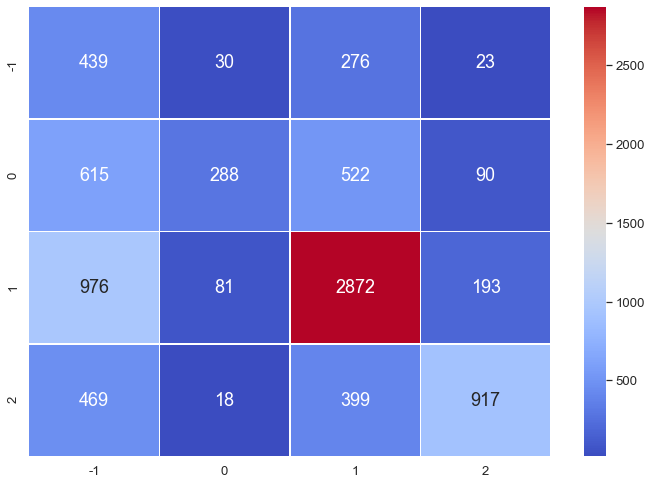

-1 0.5411332325268816
0 0.5864026698501316
1 0.7001728129067837
2 0.7467947643856647


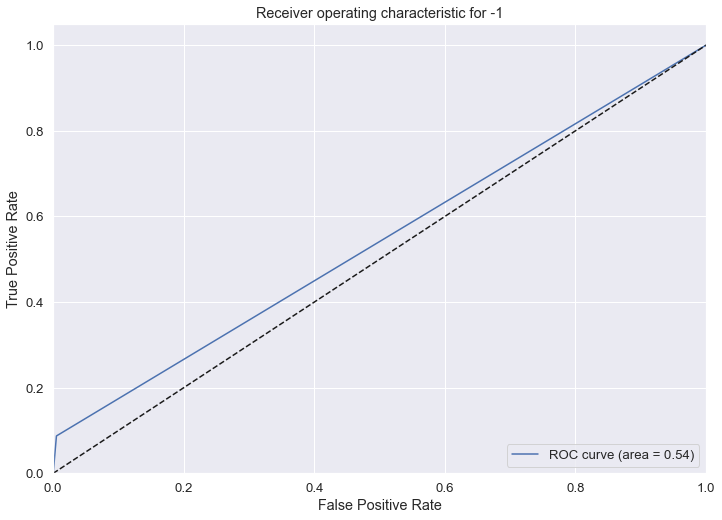

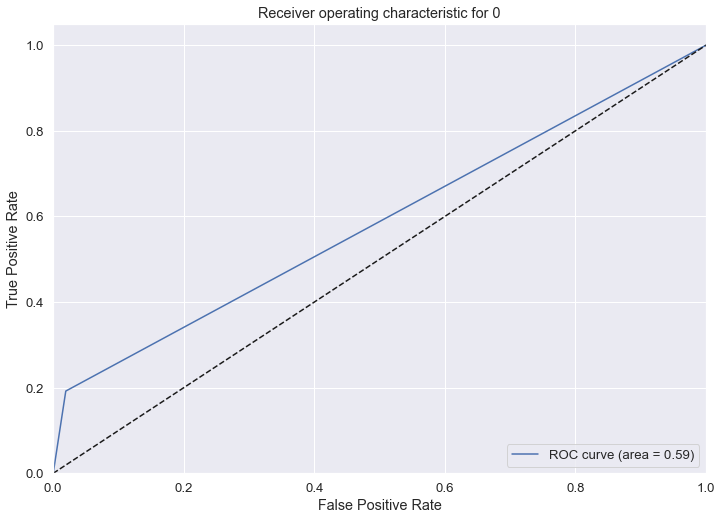

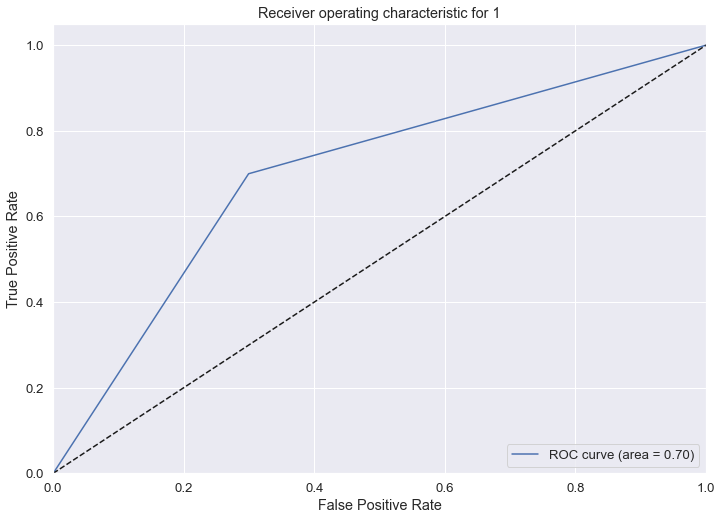

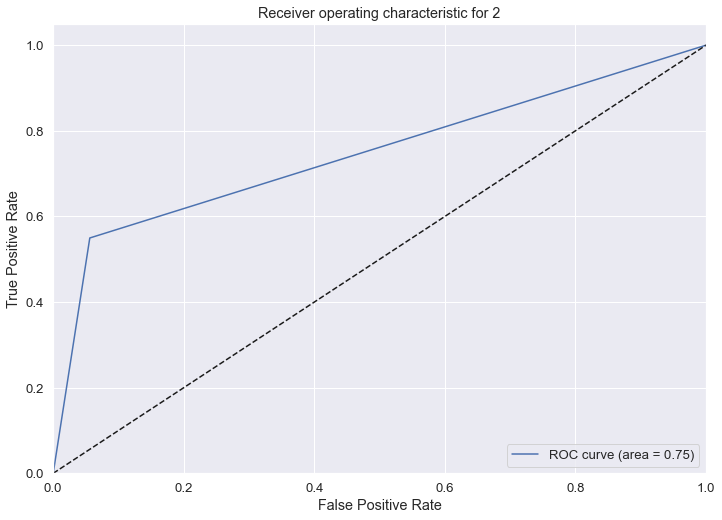

In [97]:
show_eval(y_dev_lb, y_pred_svm, lb_trained, clf_svm)

# RF

**RF binary**

In [98]:
from sklearn.ensemble import RandomForestClassifier
rfc_lb = RandomForestClassifier(n_estimators=500, max_depth=None, random_state=42, n_jobs=-1, verbose=1)
rfc_lb.fit(X_train_wv_g, y_train_lb)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.1s finished
<ipython-input-99-8840da49aa83>:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_score_rfc = np.column_stack(classes_proba)


              precision    recall  f1-score   support

          -1       0.90      0.05      0.09       768
           0       0.62      0.25      0.35      1515
           1       0.60      0.93      0.73      4122
           2       0.80      0.51      0.62      1803

    accuracy                           0.63      8208
   macro avg       0.73      0.43      0.45      8208
weighted avg       0.67      0.63      0.58      8208



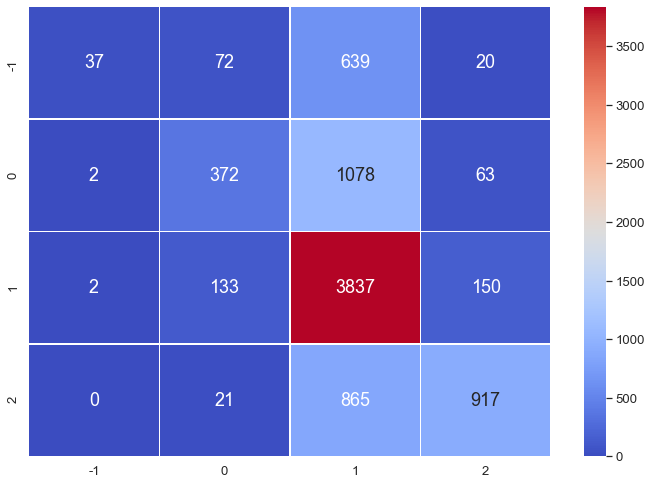

-1 0.8148735894097222
0 0.7780037170010143
1 0.7824473658648612
2 0.8987485078862838


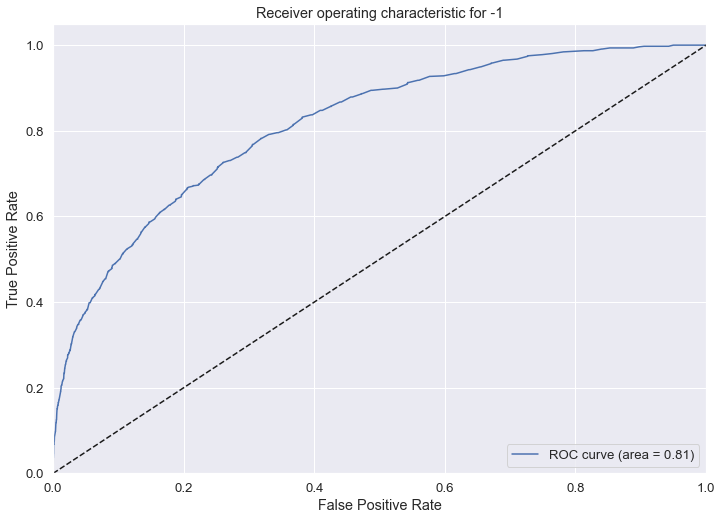

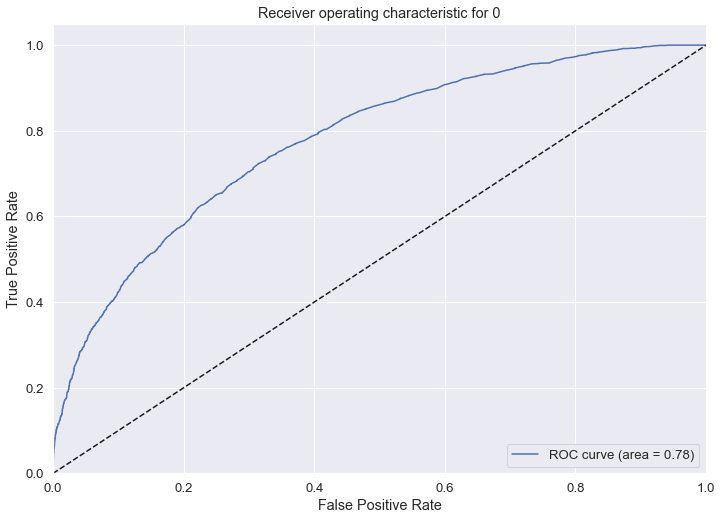

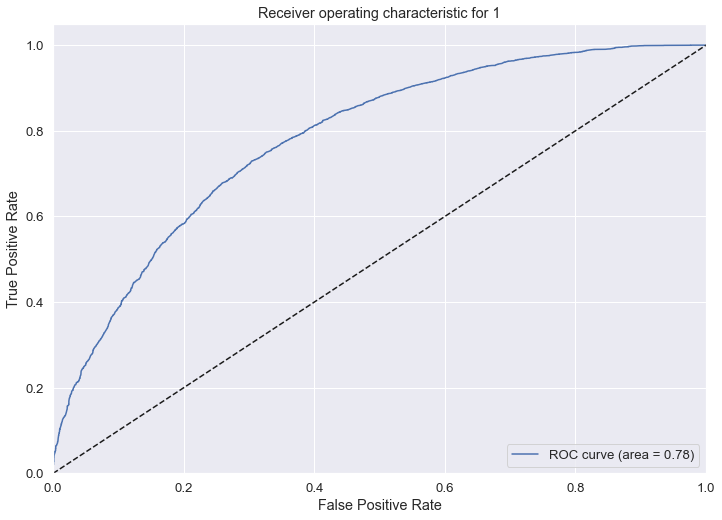

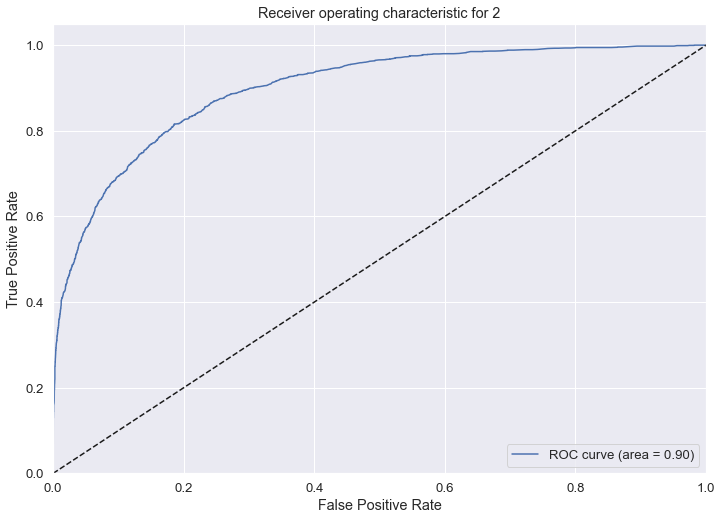

In [99]:
y_score_rfc = rfc_lb.predict_proba(X_dev_wv_g)
y_score_rfc = np.array(y_score_rfc) 
classes_proba = (class_binary_proba[:,1] for class_binary_proba in y_score_rfc)
y_score_rfc = np.column_stack(classes_proba)

show_eval(y_dev_lb, y_score_rfc, lb_trained, rfc_lb )

In [100]:
confusion_matrix(lb_trained.inverse_transform(y_train_lb), lb_trained.inverse_transform(rfc_lb.predict(X_train_wv_g)), labels=[-1,  1,  2,  0])


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.3s finished


array([[ 2283,     1,     4,     6],
       [   13, 12296,     9,    16],
       [    8,     6,  5456,     1],
       [    9,     3,     0,  4513]])

In [101]:
confusion_matrix(y_train, lb_trained.inverse_transform(rfc_lb.predict(X_train_wv_g)), labels=[-1,  0,  1,  2])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.5s finished


array([[ 2283,     6,     1,     4],
       [    9,  4513,     3,     0],
       [   13,    16, 12296,     9],
       [    8,     1,     6,  5456]])

**RF**

In [102]:
# GridsearchCV with Random Forest + Pipeline

rfc = RandomForestClassifier()

parameters5 = {'n_estimators': [30, 100]} # defining parameter space
clf5 = GridSearchCV(rfc, parameters5, cv=3)
clf5.fit(X_train_wv_g, y_train)
print('Returned hyperparameter: {}'.format(clf5.best_params_))
print('Classification accuracy on train is: {}'.format(clf5.score(X_train_wv_g, y_train)))
print('Classification accuracy on test is: {}'.format(clf5.score(X_dev_wv_g, y_dev)))

Returned hyperparameter: {'n_estimators': 100}
Classification accuracy on train is: 0.9974415204678363
Classification accuracy on test is: 0.6243908382066277


We have a slightly better accuracy than the SVM's one, but the RandomForest overfits.

In [103]:
labels = [-1,  0,  1,  2]

In [104]:
confusion_matrix(y_dev, clf5.predict(X_dev_wv_g), labels=[-1,  1,  2,  0])

array([[  43,  625,   22,   78],
       [   6, 3786,  182,  148],
       [   0,  862,  914,   27],
       [   3, 1049,   81,  382]])

In [105]:
labels=[-1,  1,  0,  2]
cm=confusion_matrix(y_dev, clf5.predict(X_dev_wv_g), labels=[-1,  1,  0,  2])
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
df_cm

,-1,1,0,2
-1,43,625,78,22
1,6,3786,148,182
0,3,1049,382,81
2,0,862,27,914


In [106]:
cm=confusion_matrix(y_dev, clf5.predict(X_dev_wv_g))
labels = [-1,  0,  1,  2]
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
df_cm

,-1,0,1,2
-1,43,78,625,22
0,3,382,1049,81
1,6,148,3786,182
2,0,27,862,914


# KNN

In [107]:
# GridSearchCV with kNN : a simple baseline
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier() # defining classifier
parameters = {'n_neighbors': [1, 2, 3, 4, 5]} # defining parameter space
clf = GridSearchCV(knn, parameters, cv=3)
clf.fit(X_train_wv_g, y_train)

print('Returned hyperparameter: {}'.format(clf.best_params_))
print('Best classification accuracy in train is: {}'.format(clf.best_score_))
print('Classification accuracy on test is: {}'.format(clf.score(X_dev_wv_g, y_dev)))

Returned hyperparameter: {'n_neighbors': 5}
Best classification accuracy in train is: 0.5918209876543209
Classification accuracy on test is: 0.6067251461988304


# 8.3. TRAIN word2vec-google-news-300

In [108]:
from gensim.models import Word2Vec
 

 
# size option needs to be set to 300 to be the same as Google's pre-trained model
 
word2vec_model = Word2Vec(size = 300, window=5, min_count = 1, workers = 2)
 
word2vec_model.build_vocab(X_cleaned)
 
# assign the vectors to the vocabs that are in Google's pre-trained model and your sentences defined above.
 
# lockf needs to be set to 1.0 to allow continued training.
 
word2vec_model.intersect_word2vec_format('/Users/Hou/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', lockf=1.0, binary=True)
 
# continue training with you own data
 
word2vec_model.train(X_cleaned, total_examples=3, epochs = 5)


(2033541, 2476125)

In [109]:
X_train_gn=tokens2vectors(X_train, word2vec_model, 300)

In [110]:
X_dev_gn=tokens2vectors(X_dev, word2vec_model, 300)

In [111]:
X_test_gn=tokens2vectors(X_test, word2vec_model, 300)

**Prediction**

In [112]:
svc = LinearSVC(verbose=1, random_state=42)
clf_svm = OneVsRestClassifier(svc, n_jobs=-1 ).fit(X_train_gn, y_train_lb)

In [113]:
y_pred_svm = clf_svm.predict(X_dev_gn)
print(y_pred_svm.shape)
y_score_svm = clf_svm.decision_function(X_dev_gn)

(8208, 4)


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       768
           0       0.00      0.00      0.00      1515
           1       0.50      1.00      0.67      4122
           2       0.00      0.00      0.00      1803

    accuracy                           0.50      8208
   macro avg       0.13      0.25      0.17      8208
weighted avg       0.25      0.50      0.34      8208



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


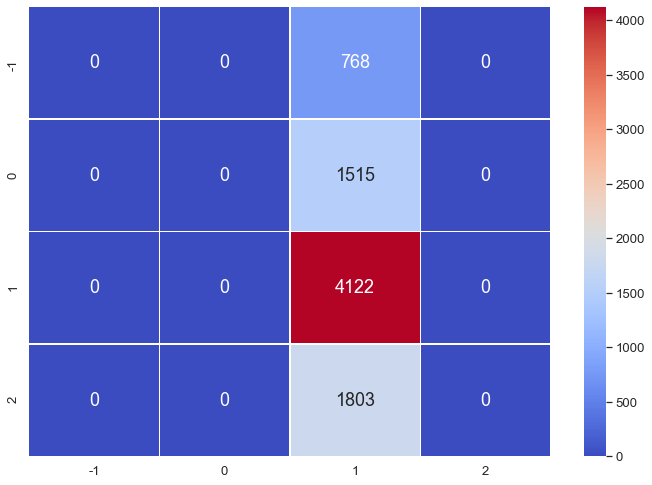

-1 0.5
0 0.5
1 0.5
2 0.5


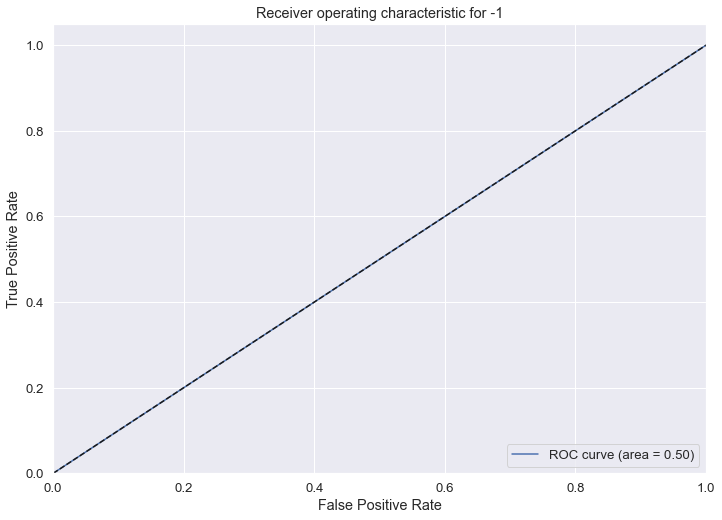

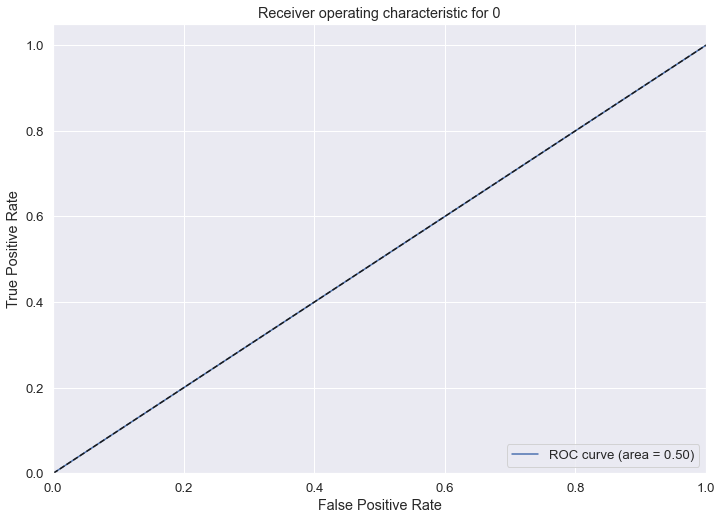

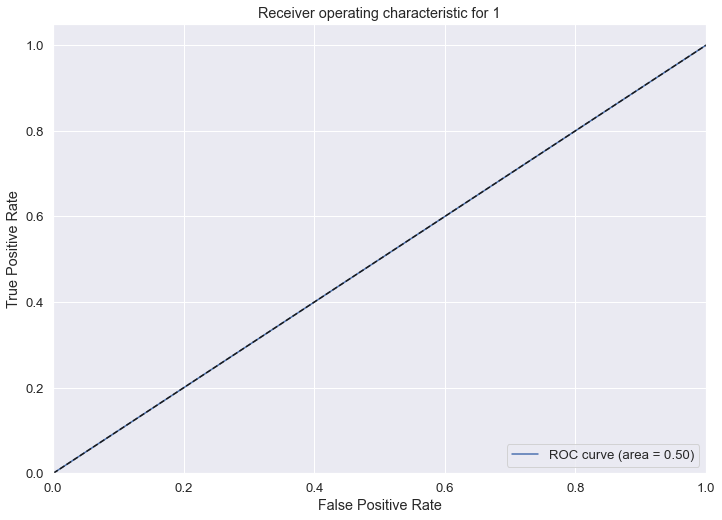

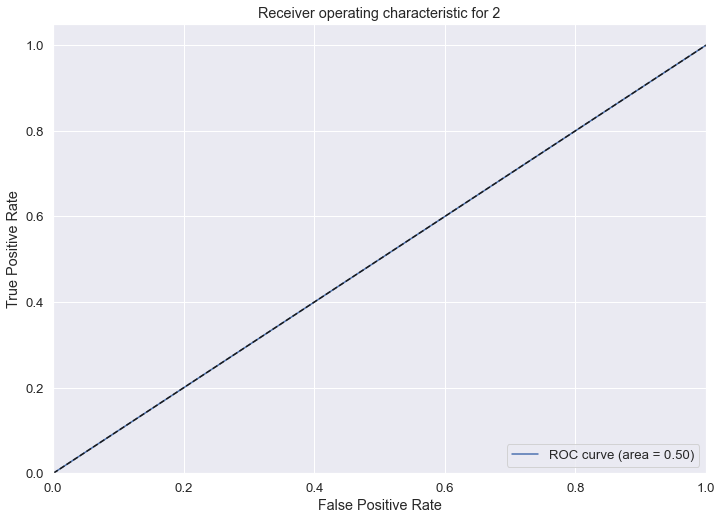

In [114]:
show_eval(y_dev_lb, y_pred_svm, lb_trained, clf_svm)

In [115]:
rfc = RandomForestClassifier()


parameters5 = {'n_estimators': [30, 100, 200]} # defining parameter space
clf5 = GridSearchCV(rfc, parameters5, cv=3)
clf5.fit(X_train_gn, y_train)
print('Returned hyperparameter: {}'.format(clf5.best_params_))
print('Classification accuracy on train is: {}'.format(clf5.score(X_train_gn, y_train)))
print('Classification accuracy on test is: {}'.format(clf5.score(X_dev_gn, y_dev)))

Returned hyperparameter: {'n_estimators': 30}
Classification accuracy on train is: 0.500893437296946
Classification accuracy on test is: 0.5021929824561403


# 8.4. Bert 

In [116]:
!pip install datasets
!pip install transformers

In [117]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

## cleaning tweets before preprocessing using Bert

In the previous models, our scores were not good. The reason could be that our clean process was not very complete because we could have some special characters that still remained. Here we used another cleaning function that removes some special characters before the tokenization. 

In [118]:

def tokenized_cleaned_tweets1(corpus):
    tokenizer = TweetTokenizer() 
    tokenized_sentences = []
    for sample in tqdm(corpus):
        pat = r'[^a-zA-z0-9.,!?/:;@#\"\'\s]' 
        sample=re.sub(pat, '', sample) #remove special characters in tweet
        sample=re.sub('[0-9]+', '', sample) #remove numbers in the tweet
        tokens = tokenizer.tokenize(sample)
        tokens = remove_url(tokens)
        tokens = remove_html(tokens)
        tokens = remove_hashtags(tokens)
        tokens = remove_retweet(tokens)
        tokens = remove_name(tokens)
        tokens = remove_punctuation(tokens)
        #tokens = remove_word(tokens)  #removing some words
        tokens = list(map(lambda x: x.lower(), tokens))
        tokenized_sentences.append(tokens)
    return tokenized_sentences

In [119]:
#We replace label -1 by 3 because our model gives some message errors with negative labels 
df2=data2.copy()
df2.loc[df2['sentiment'] == -1,'sentiment'] = 3 #replacing the label -1 by 3
print(df2.shape)
df2['sentiment'].unique()

(41041, 2)


array([3, 1, 2, 0])

In [120]:
X_bert=tokenized_cleaned_tweets1(df2['message']) 
y=list(df2['sentiment'])

100%|██████████| 41041/41041 [00:05<00:00, 8202.60it/s]


In [121]:
X_bert= [' '.join(x) for x in X_bert]
print(len(X_bert), X_bert[2])

41041 fabulous leonardo dicaprio's film on climate change is brilliant do watch via youtube


## Splitting the data set

In [122]:
# create train 60% 
X_train, X_devtest, y_train, y_devtest = train_test_split(X_bert, y, test_size=0.4, random_state=42)

In [123]:
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)

**Importing BERT Model and BERT Tokenizer**

In [124]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [125]:
# sample data
tweets = X_bert[0:2]
print(tweets)

# encoding tweets to 
sent_id = tokenizer.batch_encode_plus(tweets, padding=True, add_special_tokens = True, return_token_type_ids=False)

['tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for yes while the suv boom', 'natgeochannel watch beforetheflood right here as leodicaprio travels the world to tackle climate change htt']


In [126]:
print(sent_id)

{'input_ids': [[101, 9543, 2666, 4783, 19092, 4785, 2689, 2003, 2019, 5875, 15876, 22516, 2004, 2009, 2001, 3795, 12959, 2021, 1996, 4774, 3030, 12959, 2005, 2748, 2096, 1996, 15620, 8797, 102], [101, 14085, 3351, 11663, 20147, 2140, 3422, 2077, 10760, 10258, 17139, 2157, 2182, 2004, 6688, 14808, 9331, 9488, 7930, 1996, 2088, 2000, 11147, 4785, 2689, 1044, 4779, 102, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]}


In [127]:
# len
print(len(sent_id['input_ids'][0]))

29


## Tokenization

In [128]:
max_seq_len = 30 
# tokenize and encode tweets in the training set
tokens_train= tokenizer.batch_encode_plus(X_train, max_length = max_seq_len, pad_to_max_length=True, add_special_tokens = True, truncation=True, return_token_type_ids=False)

# tokenize and encode tweets in the validation set
tokens_dev = tokenizer.batch_encode_plus(X_dev, max_length = max_seq_len, pad_to_max_length=True, add_special_tokens = True, truncation=True, return_token_type_ids=False)

# tokenize and encode tweets in the test set
tokens_test = tokenizer.batch_encode_plus(X_test, max_length = max_seq_len, pad_to_max_length=True, add_special_tokens = True, truncation=True, return_token_type_ids=False)

/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


##  Convert Integer Sequences to Tensors

In [129]:
# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train)

# for validation set
dev_seq = torch.tensor(tokens_dev['input_ids'])
dev_mask = torch.tensor(tokens_dev['attention_mask'])
dev_y = torch.tensor(y_dev)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test)

In [130]:
print(train_seq.shape)
print(train_mask.shape)
print(train_y.shape)

torch.Size([24624, 30])
torch.Size([24624, 30])
torch.Size([24624])


## Create DataLoaders

In [131]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)

# sampler for sampling the data during training
dev_sampler = SequentialSampler(dev_data)

# dataLoader for validation set
dev_dataloader = DataLoader(dev_data, sampler = dev_sampler, batch_size=batch_size)

### 8.4.1. Model

In [133]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
use_cuda=False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# push the model to GPU
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [134]:
# Define the optimizer

optimizer = AdamW(model.parameters(),
                  lr = 2e-5 # args.learning_rate - default is 5e-5, our notebook had 2e-5, eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
                       

#optimizer = AdamW(model.parameters(), lr = 1e-3)

In [135]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### 8.4.2. Training loop

We define a function to compute time in a format H:M:S

In [136]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [137]:
format_time(180)

'0:03:00'

Function to compute the accuracy

In [138]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

We define the training function:

 Training phase

In [139]:
def train_epoch(model, train_dataloader):
    
    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss and total accuracy for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
       # Progress update every 50 batches.
       if step % 100 == 0 and not step == 0:
         # Calculate elapsed time in minutes.
         elapsed = format_time(time.time() - t0)
            
         # Report progress.
         print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       # Unpack this training batch from our dataloader. 
       b_input_ids = batch[0].to(device)
       b_input_mask = batch[1].to(device)
       b_labels = batch[2].to(device)

       # Always clear any previously calculated gradients before performing a
        
       model.zero_grad()        

       # Perform a forward pass (evaluate the model on this training batch).
       loss= model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)[0]
       logits=model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)[1] 

       # Accumulate the training loss over all of the batches so that we can
       # calculate the average loss at the end.
       total_train_loss += loss.item()

       # Move logits and labels to CPU
       logits = logits.detach().cpu().numpy()
       label_ids = b_labels.to('cpu').numpy()

       # Calculate the accuracy for this batch of test sentences, and
       # accumulate it over all batches.
       total_train_accuracy += flat_accuracy(logits, label_ids)
        

  
       # Perform a backward pass to calculate the gradients.
       loss.backward()

       # Clip the norm of the gradients to 1.0.
       # This is to help prevent the "exploding gradients" problem.
       torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

       # Update parameters and take a step using the computed gradient.
       optimizer.step()

       # Update the learning rate.
       scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader) 

    # Report the final accuracy for this validation run.
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)


           
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    return avg_train_accuracy, avg_train_loss, training_time

Validation phase

In [140]:
def validation(model, validation_dataloader):
   t0 = time.time()
   # Put the model in evaluation mode
   model.eval()

   # Tracking variables 
   total_eval_accuracy = 0
   total_eval_loss = 0
   #nb_eval_steps = 0

   # Evaluate data for one epoch
   for step, batch in enumerate(validation_dataloader):
       # Progress update every 100 batches.
       if step % 100 == 0 and not step == 0:
         # Calculate elapsed time in minutes.
         elapsed = format_time(time.time() - t0)
            
         # Report progress.
         print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))
       #Unpack the batch 
       b_input_ids = batch[0].to(device)
       b_input_mask = batch[1].to(device)
       b_labels = batch[2].to(device)
        
       # Tell pytorch not to bother with constructing the compute graph during
       # the forward pass, since this is only needed for backprop (training).
       with torch.no_grad():
         # Forward pass, calculate logit predictions
         # Get the "logits" output by the model. The "logits" are the output
         # values prior to applying an activation function like the softmax.
         loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)[0]
         logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)[1]
            
       # Accumulate the validation loss.
       total_eval_loss += loss.item()

       # Move logits and labels to CPU
       logits = logits.detach().cpu().numpy()
       label_ids = b_labels.to('cpu').numpy()

       # Calculate the accuracy for this batch of test sentences, and
       # accumulate it over all batches.
       total_eval_accuracy += flat_accuracy(logits, label_ids)
        

   # Report the final accuracy for this validation run.
   avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
   
   # Calculate the average loss over all of the batches.
   avg_val_loss = total_eval_loss / len(validation_dataloader)
    
   # Measure how long the validation run took.
   validation_time = format_time(time.time() - t0)
   return avg_val_accuracy,avg_val_loss, validation_time

Putting the previous functions together 

In [141]:
def train(model, train_dataloader,validation_dataloader,epochs=2):
  # We'll store a number of quantities such as training and validation loss and accuracy, 
  training_accuracies,training_losses= [],[]
  validation_accuracies,validation_losses= [],[]

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  for epoch in range(0, epochs):
      # Training phase
      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
      print('Training...')
      #Getting the accuracy, average loss over all of the batches of the training data and training time of the epoch
      avg_train_accuracy, avg_train_loss, training_time=train_epoch(model, train_dataloader)

      print("")
      print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
        
    
      #   Validation (after the completion of each training epoch, measure our performance on our validation set.

      print("")
      print("Running Validation...")

      # accuracy, average loss over all of the batches of the validation data and validation time of the epoch
      avg_val_accuracy, avg_val_loss, validation_time=validation(model, validation_dataloader)

      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_accuracies.append(avg_train_accuracy)
      training_losses.append(avg_train_loss)
      validation_accuracies.append(avg_val_accuracy)
      validation_losses.append(avg_val_loss)

  print("")
  print("Training complete!")
  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
  return training_accuracies, training_losses, validation_accuracies, validation_losses

In [142]:
train(model, train_dataloader,dev_dataloader,epochs=2)


======== Epoch 1 / 2 ========
Training...
  Batch   100  of    770.    Elapsed: 0:17:16.
  Batch   200  of    770.    Elapsed: 0:35:13.
  Batch   300  of    770.    Elapsed: 0:52:40.
  Batch   400  of    770.    Elapsed: 1:09:33.
  Batch   500  of    770.    Elapsed: 1:24:55.
  Batch   600  of    770.    Elapsed: 1:41:50.
  Batch   700  of    770.    Elapsed: 1:58:27.

  Accuracy: 0.66
  Average training loss: 0.83
  Training epcoh took: 2:10:42

Running Validation...
  Batch   100  of    257.    Elapsed: 0:06:45.
  Batch   200  of    257.    Elapsed: 0:13:15.
  Accuracy: 0.73
  Validation Loss: 0.70
  Validation took: 0:16:55

======== Epoch 2 / 2 ========
Training...
  Batch   100  of    770.    Elapsed: 0:15:20.
  Batch   200  of    770.    Elapsed: 0:30:38.
  Batch   300  of    770.    Elapsed: 0:46:00.
  Batch   400  of    770.    Elapsed: 1:01:22.
  Batch   500  of    770.    Elapsed: 1:16:43.
  Batch   600  of    770.    Elapsed: 1:32:06.
  Batch   700  of    770.    Elapsed: 1

([0.6648133116883117, 0.7818993506493507],
 [0.8262589983351819, 0.5714974804164528],
 [0.7295719844357976, 0.7481760700389105],
 [0.7000307673842062, 0.6577125627706951])

We can see that our BERT model does not overfit. Also, we counld't tune the parameters (learning rate, epochs, max_seq_len) of our model because of the time complexity issue. In fact, the average time to train the model with 2 epochs is 4:42:27.

### Get Predictions for Test Data

**Quantitative evaluation**

In [143]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), token_type_ids=None, attention_mask=test_mask.to(device),labels=test_y.to(device))[1]
  #model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)[1]
  preds = preds.detach().cpu().numpy()

# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

# confusion matrix
pd.crosstab(test_y, preds)

              precision    recall  f1-score   support

           0       0.61      0.50      0.55      1465
           1       0.77      0.83      0.80      4149
           2       0.77      0.82      0.80      1799
           3       0.65      0.52      0.58       796

    accuracy                           0.74      8209
   macro avg       0.70      0.67      0.68      8209
weighted avg       0.73      0.74      0.73      8209



col_0,0,1,2,3
row_0,,,,
0,734,549,82,100
1,287,3433,324,105
2,44,257,1482,16
3,132,218,35,411


According to our quantitative evaluation, we can observe that our predictor predict very well when the true label is 1 and 2, but it does not perform that well on the neutral and the anti tweets. The accuracy and the F1 score are much more better that the ones obtained based on the Word2Vec. Our best model for this sentiments analysis is BERT.

**Qualitative analysis of our prediction**

In [169]:
y_pred2=preds.tolist()

d2 = {'Cleaned_tweet': X_test, 
      'True sentiment': test_y.tolist(), 
     'Predicted sentiment': y_pred2}
data4 = pd.DataFrame(data=d2)
data4=data4.reset_index()

data4['Good prediction']=data4['True sentiment']==data4['Predicted sentiment']


In [183]:
good_predictions=data4.loc[data4['True sentiment']==data4['Predicted sentiment']]
good_predictions.head()

,index,Cleaned_tweet,True sentiment,Predicted sentiment,Good prediction
1,1,slate trump says nobody really knows if climat...,2,2,True
3,3,thinkprogress los angeles could become the nex...,2,2,True
4,4,kbx dont forget they are responsible for globa...,0,0,True
5,5,mug here are all times trump tweeted climate c...,1,1,True
6,6,senyora ang initinit ng panahon tas ang lamigl...,0,0,True


In [170]:
Data_wrong_pred=data4.loc[data4['True sentiment']!=data4['Predicted sentiment']]
Data_wrong_pred.reset_index(inplace=True)
Data_wrong_pred=Data_wrong_pred.drop(columns=['index', 'level_0'])

In [171]:
Data_wrong_pred.head()

,Cleaned_tweet,True sentiment,Predicted sentiment,Good prediction
0,nytimes climate change is expected to displace...,1,2,False
1,dailypedantry i don't know which part of what ...,0,1,False
2,climate change is an industry not a serious sc...,3,1,False
3,nasa global warming is now changing how earth ...,2,1,False
4,realdonaldtrump yay only thing concerns me ple...,0,1,False


In [172]:
# We print the first ten tweet with wrong sentiment prediction
for i in range(10):    
    print(i, Data_wrong_pred['Cleaned_tweet'][i],'.', 'y_true :', Data_wrong_pred['True sentiment'][i], 'y_pred :',
         Data_wrong_pred['Predicted sentiment'][i])

0 nytimes climate change is expected to displace millions of people china is already moving entire towns . y_true : 1 y_pred : 2
1 dailypedantry i don't know which part of what i'm saying or linking to is making you think we don't understand the causes of climate change . y_true : 0 y_pred : 1
2 climate change is an industry not a serious scientific endeavour a good example of herd instinct if ever i saw one . y_true : 3 y_pred : 1
3 nasa global warming is now changing how earth wobbles washington ap global warming is shifting the way t ... . y_true : 2 y_pred : 1
4 realdonaldtrump yay only thing concerns me please look more into climate change those boys who deny it get bi . y_true : 0 y_pred : 1
5 robellcampbin rtpt blog comments from climate change to treasonous us congress amp accusations of paedophilia in just easy steps htt . y_true : 0 y_pred : 1
6 when will people understand this about globalism amp not global warming enlist gt act . y_true : 3 y_pred : 1
7 extinctsymbol dormou

In the third tweet, the predictor couldn't understand that describing the climate change as an industry was in a pejorative manner. Our predictor concluded that this tweet was infavor of climate change when it is clear that it was against it.
The most of tweets observed above seem very ambigious even for a human being. Our predictor couldn't assimilate the complexity of tweets understanding. This could in part explain the scores that we obtained.

In [181]:
Data_wrong_pred['Predicted sentiment'].value_counts(normalize=True)

1    0.476501
0    0.215449
2    0.205212
3    0.102839
Name: Predicted sentiment, dtype: float64

In [184]:
Data_wrong_pred['True sentiment'].value_counts(normalize=True)

0    0.340158
1    0.333178
3    0.179153
2    0.147510
Name: True sentiment, dtype: float64

We can also conclude that (as for the tweets observed above) our predictor tends more to predict the sentiment 1 when making wrong predictions. This could be caused by the fact that our dataset is not balanced.